`Problem Statement` - The aim here will be to predict the medical costs billed by health insurance on an individual given some features about the individual in the dataset.

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

-  Here as per task it is required to predict the charges billed by medical insurance on an individual based on some given features
-  Here `charges` is the target feature which is numerical
-  All other columns can be used as input features to predict the target
-  Regression task
-  Mean absolute error and R2_Score metrics are being used

In [18]:
# Load and preprocess the dataset
dataset = pd.read_csv('/content/insurance.csv')
dataset.dropna(how='any', axis=0, inplace=True)
dataset.drop_duplicates(keep='first', inplace=True)
dataset['charges'] = dataset['charges'].round()

In [19]:
dataset.shape

(1337, 7)

In [20]:
# Feature Engineering and One-Hot Encoding

X = dataset.drop('charges', axis=1)
y = pd.DataFrame(dataset['charges'])

categorical_cols = ['sex', 'smoker', 'region']
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols)],
                           remainder='passthrough')
X = ct.fit_transform(X)

column_names = list(ct.get_feature_names_out())
X = pd.DataFrame(X, columns=column_names)

In [21]:
# Train-Test Split and Feature Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=36)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
# Create a function for model training and evaluation

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    if model in ['SVM_rsv','DT_rsv'] :
      model.fit(X_train, y_train)
      best_estimator = model.best_estimator_

      y_pred = best_estimator.predict(X_test)
      y_pred_train = best_estimator.predict(X_train)

      test_mae = mean_absolute_error(y_test,y_pred)
      train_mae = mean_absolute_error(y_train,y_pred_train)

      test_score = r2_score(y_test, y_pred)
      train_score = r2_score(y_train , y_pred_train)

      return model, test_mae , train_mae , test_score*100 , train_score*100

    else :
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      y_pred_train = model.predict(X_train)

      test_mae = mean_absolute_error(y_test,y_pred)
      train_mae = mean_absolute_error(y_train,y_pred_train)

      test_score = r2_score(y_test, y_pred)
      train_score = r2_score(y_train , y_pred_train)

      return model, test_mae , train_mae , test_score*100 , train_score*100

In [23]:
# using randomized search cv in decision trees

dtr_model = DecisionTreeRegressor()

max_depth = np.linspace(3, 10, 6, dtype="int")
min_samples_split = [2, 5, 10, 15, 30, 35]
min_samples_leaf = [1, 2, 5, 10, 15, 20, 25]
criterion = ['absolute_error', 'squared_error']
min_impurity_decrease = np.linspace(0.0001, 0.0005, 8)

param_grid = {
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "criterion": criterion,
        "min_impurity_decrease": min_impurity_decrease
    }

In [24]:
# using randomized search cv in SVR

svr = SVR()

param_dist = {
    'kernel': ['linear', 'rbf', 'poly'],'C': np.linspace(0.1, 10),'gamma': stats.expon(scale=0.1),'epsilon': np.linspace(0.01, 0.1)
    }

-  For SVR and Decision Tree model randomized search CV is being used for better model performances
-  Because in SVR without random search cv very poor performance observed and in case of decision trees without hyper parameter tuning it will obviously lead to overfitting problem

In [25]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear Regression' : LinearRegression() ,
    'Random Forest': RandomForestRegressor(n_estimators=8, criterion='absolute_error', max_depth=6),
    'KNN': KNeighborsRegressor(n_neighbors=4, p=1),
    'SVM_rsv': RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=150, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    verbose=1, random_state=42 ),
    'DT_rsv': RandomizedSearchCV(dtr_model, param_distributions=param_grid, n_iter=500, scoring="r2", cv=3, n_jobs=-1, verbose=5)
}

In [26]:
# Model Evaluation Dictionary
test_r2_score = {}
test_mae = {}

train_r2_score = {}
train_mae = {}

for model_name, model in models.items():
    model, mae_test , mae_train , test_r2 , train_r2 = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

    test_r2_score[model_name] = (model , test_r2)
    train_r2_score[model_name] = (model , train_r2)

    test_mae[model_name] = (model , mae_test)
    train_mae[model_name] = (model , mae_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-22-e48ba9737fe9>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [27]:
# Print r2_score results
for model_name, (_, test_score) in test_r2_score.items():
    print('Test and Train r2_scores for each model')
    print(f'{model_name} Test Score: {test_score}  Train Score:{train_r2_score[model_name][1]}')

print()

# Print mae results
for model_name, (_, mae) in test_mae.items():
    print('Test and Train mae  for each model')
    print(f'{model_name} Test mae: {mae}  Train mae:{train_mae[model_name][1]}')

Test and Train r2_scores for each model
Logistic Regression Test Score: 66.5386829463384  Train Score:79.49955876954527
Test and Train r2_scores for each model
Linear Regression Test Score: 75.40233391599972  Train Score:74.86437540593911
Test and Train r2_scores for each model
Random Forest Test Score: 84.65321233251967  Train Score:88.07705293193526
Test and Train r2_scores for each model
KNN Test Score: 77.39674855813028  Train Score:87.6564006765879
Test and Train r2_scores for each model
SVM_rsv Test Score: 49.97364997891707  Train Score:47.18922285393825
Test and Train r2_scores for each model
DT_rsv Test Score: 84.63014199528608  Train Score:86.74841456718183

Test and Train mae  for each model
Logistic Regression Test mae: 3726.4850746268658  Train mae:2686.8606173994385
Test and Train mae  for each model
Linear Regression Test mae: 3641.9393352618267  Train mae:4320.130029876912
Test and Train mae  for each model
Random Forest Test mae: 1920.0708955223881  Train mae:1696.66352

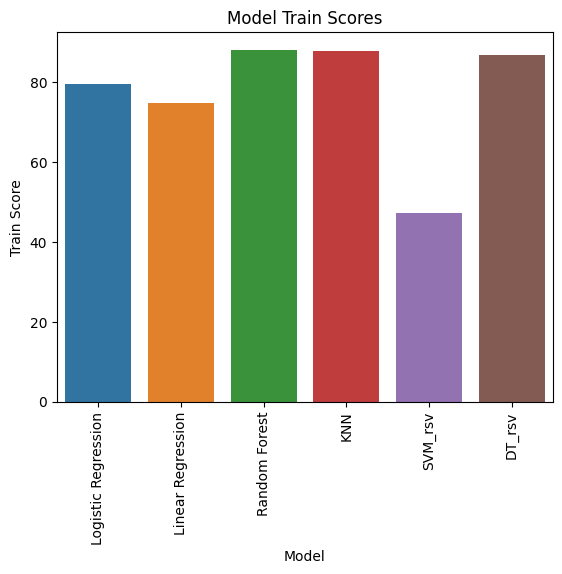

In [29]:
# Plot train scores
sns.barplot(x=list(train_r2_score.keys()), y=[score for _, score in train_r2_score.values()])
plt.title('Model Train Scores')
plt.xlabel('Model')
plt.ylabel('Train Score')
plt.xticks(rotation=90)
plt.show()

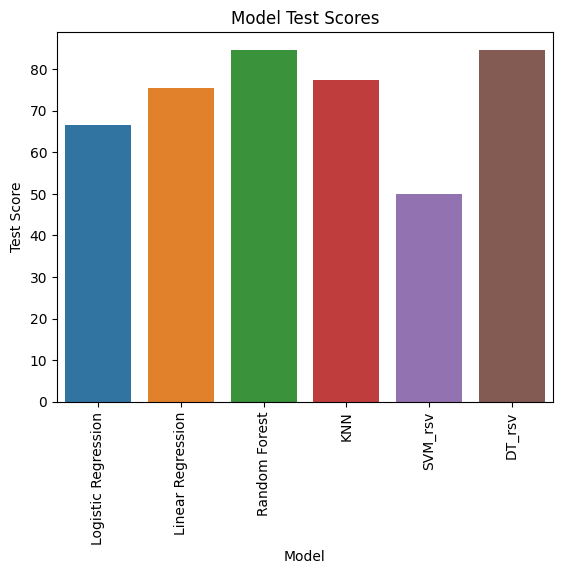

In [30]:
# Plot test scores
sns.barplot(x=list(test_r2_score.keys()), y=[score for _, score in test_r2_score.values()])
plt.title('Model Test Scores')
plt.xlabel('Model')
plt.ylabel('Test Score')
plt.xticks(rotation=90)
plt.show()

### Conclusion
- Performances of Random forest , Decision Tree with random search cv are better
- SVR performance does not seem to be that good even after hyper parameter tuning with random search cv
- Logistic regression primarily not used for regression tasks but checked its performance also which is not upto mark